## Library Load

In [1]:
## models
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import GradientBoostingClassifier as GBM
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier, Pool

## sklearn 
from sklearn.preprocessing import LabelEncoder
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score as roc
from sklearn.preprocessing import RobustScaler , StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import f1_score

## utils
from itertools import product, chain
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import sys
import pickle
from pycm import * 
## custom
print(sys.version)
sys.path.append('/home/advice/Python/SR/Custom/')
from cat_num_corrplot import *
from Init import *
from CompressData import *
from visualization import *
from utility import * 

scaler = RobustScaler()
le = LabelEncoder()

import warnings
warnings.filterwarnings("ignore")


3.6.7 | packaged by conda-forge | (default, Feb 28 2019, 09:07:38) 
[GCC 7.3.0]

    사용하면 좋은 패키지
    train_validation_test_split / cat2dict / code2cat / colorlist / onehotencoding / roccurve  / ProbDensity
    pycm import *  
    ConfusionMatrix(actual_vector=``test_y``, predict_vector= ``pred`` ) 
    사용하면 통계량값 다 얻을 수 있음
    


# 1. UMAP을 이용해서 시각화 했을 때 분리되는 것을 바탕으로 어떠한 데이터인지?? 데이터를 좀 더 심화하기
# 2. Catboost , lightgbm , UMAP 의 작동원리는 먼지?
## 확실하게 알기! 
# 3. Bayesian Optimization

# Accuracy에 대해서 어떠한 기준으로 할 지 
## 잘 안나온다는 근거!
## score 분포가 정규성을 가지게 자체적으로 기업에 대한 다양하게 하고 있는데, 마스터 그레이드를 만들어서 금융감독원이 보는 표준이 있어서 
# 데이터 EDA를 좀 더 잘하고, 
# Feature Engineering를 좀 더 해서 Feature를 뽑아 낼 수 있는지? 
* 생각해본 것 Date를 좀 더 쪼개서 표현 할 수 있지 않을까?
*  Location을 Embedding만 따로 잘 학습을 해서, 대체해서 넣으면 효과가 있지 않을까?

In [2]:
data = pd.read_csv("./../Data/Rain/GAIN_Data.csv")

In [3]:
import pickle ,re 
with open("./Umap_Output/index_info.p", "rb") as p :
    index_info = pickle.load(p)

In [4]:
def ProbDensity(prob , idx , title = "") :
    try :
        sns.distplot(prob[idx], label = "rain" ) 
        sns.distplot(prob[~idx], label = "not rain" ).set_title( title , fontsize = 20) 
    except :
        sns.distplot(prob[idx,1], label = "rain" ) 
        sns.distplot(prob[~idx,1], label = "not rain").set_title( title , fontsize = 20) 

In [9]:
from datetime import datetime
year = lambda x: datetime.strptime(x, "%Y-%m-%d" ).year
day_of_week = lambda x: datetime.strptime(x, "%Y-%m-%d" ).weekday()
month = lambda x: datetime.strptime(x, "%Y-%m-%d" ).month
week_number = lambda x: datetime.strptime(x, "%Y-%m-%d" ).strftime('%V')
data['year'] = data['Date'].map(year)
data["day_of_week"] = data["Date"].map(day_of_week)
data['month'] = data['Date'].map(month)
data["week_number"] = data["Date"].map(week_number)
data = data.drop(["RISK_MM"], axis = 1) # 'Location'  'Date' 

In [10]:
data[["year","day_of_week", "month","week_number"]] = data[["year","day_of_week", "month","week_number"]].astype("object")

In [11]:
catcols = data.select_dtypes("object").columns.tolist()
print(catcols)

['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow', 'Date', 'year', 'day_of_week', 'month', 'week_number']


In [12]:
data2 = data.copy()

In [13]:
## Location 과 달별로 평균 햇빛량 
newdata = data.groupby(['Location','month', "day_of_week"], group_keys=False).\
agg({"Sunshine" : ["mean","std"],"Humidity3pm" :["mean","std"] , "Pressure3pm" :["mean","std"] }).reset_index()
newdata.columns = ["Location", 'month', "day_of_week" , 
                   "Shunshine_mean","Shunshine_std",
                   "Humidity3pm_mean", "Humidity3pm_std",
                   "Pressure3pm_mean", "Pressure3pm_std"
                  ]
print(newdata.head())
data = pd.merge(data2, newdata, how='left')

   Location  month  day_of_week  Shunshine_mean  Shunshine_std  \
0  Adelaide      1            0       10.218895       3.898430   
1  Adelaide      1            1        9.261932       4.489069   
2  Adelaide      1            2       10.458043       3.444014   
3  Adelaide      1            3        9.967706       4.244898   
4  Adelaide      1            4        9.802007       3.751733   

   Humidity3pm_mean  Humidity3pm_std  Pressure3pm_mean  Pressure3pm_std  
0         31.051282        18.444724       1011.735895         4.121223  
1         32.054132        16.499074        994.915328       103.968874  
2         34.567072        14.589849        997.045434        95.096990  
3         31.025000        18.741819       1010.972499         5.876249  
4         33.575000        17.959909       1011.015002         5.366544  


## Category 변수를 Numeric으로 안에서 자동을 변환해주는 것이 내장되어있는 Ligthgbm, Catboost

## CatBoost

In [17]:
cat_x = data.drop(columns = ["RainTomorrow"] , axis = 1)
cat_y = data["RainTomorrow"]
cat_y = np.where(cat_y == "Yes", 1, 0)
cat_x[numeric_feature] = pd.DataFrame(scaler.fit_transform(cat_x[numeric_feature].values) , columns = numeric_feature )
cat_features = np.where(cat_x.dtypes.astype("str").isin(["category","object"]))[0]
catX_train, catX_Test, caty_train, caty_Test =\
cat_x.iloc[index_info[0],] , cat_x.iloc[index_info[1],]  , cat_y[index_info[0]] , cat_y[index_info[1]]
catX_train.reset_index(drop = True ,inplace= True)
catX_Test.reset_index(drop = True ,inplace= True)
train_umap.reset_index(drop = True ,inplace= True)
test_umap.reset_index(drop = True ,inplace= True)

((99535, 32), (42658, 32), (99535, 36), (42658, 36))

In [18]:
print(catX_train.iloc[:,cat_features].columns.tolist())

['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'Date', 'year', 'day_of_week', 'month', 'week_number']


## **Catboost** Bayesian Optimization



In [21]:
from bayes_opt import BayesianOptimization

In [51]:
import warnings
warnings.filterwarnings("ignore")

def catboost_eval(bagging_temperature ,
                  depth , 
                  learning_rate ,
                  min_data_in_leaf , 
                  max_leaves , 
                  l2_leaf_reg , 
                  border_count):
    n_splits=5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    f1 = []
    predict = None
    params = {}
    params['iterations'] = 1000
    params['custom_loss'] = 'TotalF1'
    params['eval_metric'] = 'TotalF1'
    params['random_seed'] = 1234
    params['learning_rate'] = learning_rate
    params['min_data_in_leaf'] = int(round(min_data_in_leaf))
    params['depth'] = int(round(depth))
    #params['max_leaves'] = int(round(max_leaves))
    #params['l2_leaf_reg'] = int(round(l2_leaf_reg))
    params['border_count'] = int(round(border_count))
    params['bagging_temperature'] = int(round(bagging_temperature))
    X , y = catX_train.values , caty_train
    for tr_ind, val_ind in skf.split(X , y):
        X_train = X[tr_ind]
        y_train = y[tr_ind]
        X_valid = X[val_ind]
        y_valid = y[val_ind]
        ## https://catboost.ai/docs/concepts/python-reference_catboost_eval-metrics.html
        clf = CatBoostClassifier(**params , 
                                 task_type = "GPU" , 
                                 leaf_estimation_iterations = 10,
                                 use_best_model=True,
                                 od_type="Iter",
                                 logging_level='Silent',
                                )
        clf.fit(X_train, 
                y_train,
                cat_features=cat_features,
                eval_set=(X_valid, y_valid),
                verbose = False ,
        )
        
        y_pred = clf.predict(X_valid)
        
        f1_value = f1_score(y_valid.astype(int) ,
                            y_pred.astype(int)  ,
                            average='weighted')
        f1.append(f1_value)
    return sum(f1)/n_splits

## min_data_in_leaf , max_leaves , 추가 하니 먼가 잘 안됨.
catBO = BayesianOptimization(catboost_eval,
                             {'bagging_temperature': (0, 10),
                              'depth': (5, 8.99) ,
                              "learning_rate" : (0.001,0.1) , 
                              "min_data_in_leaf" : (1,6) , 
                              'max_leaves' : (200,200)  ,
                              'l2_leaf_reg': (100, 100)  ,
                              'border_count': (5, 255) ,
                             },
                             random_state=0)
init_round=5
opt_round = 10
catBO.maximize(init_points=init_round, n_iter=opt_round)
with open("catboost_GOODParam.p","wb") as wb :
    pickle.dump(catBO.max , wb)

|   iter    |  target   | baggin... | border... |   depth   | l2_lea... | learni... | max_le... | min_da... |
-------------------------------------------------------------------------------------------------------------


|  1        |  0.8428   |  5.488    |  183.8    |  7.405    |  100.0    |  0.04294  |  200.0    |  3.188    |


|  2        |  0.8504   |  8.918    |  245.9    |  6.53     |  100.0    |  0.05336  |  200.0    |  5.628    |


|  3        |  0.8613   |  0.7104   |  26.78    |  5.081    |  100.0    |  0.07804  |  200.0    |  5.893    |


|  4        |  0.8522   |  7.992    |  120.4    |  8.114    |  100.0    |  0.06435  |  200.0    |  5.723    |


|  5        |  0.8441   |  5.218    |  108.7    |  6.056    |  100.0    |  0.04616  |  200.0    |  1.094    |


|  6        |  0.8522   |  9.697    |  6.608    |  8.472    |  100.0    |  0.09572  |  200.0    |  5.98     |


|  7        |  0.8675   |  0.421    |  254.2    |  8.867    |  100.0    |  0.07286  |  200.0    |  5.924    |


|  8        |  0.8453   |  0.01484  |  50.78    |  8.704    |  100.0    |  0.01732  |  200.0    |  5.589    |


|  9        |  0.8118   |  1.353e-0 |  5.0      |  5.0      |  100.0    |  0.001    |  200.0    |  6.0      |


|  10       |  0.8466   |  10.0     |  55.3     |  5.0      |  100.0    |  0.1      |  200.0    |  6.0      |


|  11       |  0.8541   |  10.0     |  29.22    |  8.99     |  100.0    |  0.09016  |  200.0    |  1.0      |


|  12       |  0.8612   |  0.0      |  147.4    |  5.0      |  100.0    |  0.1      |  200.0    |  6.0      |


|  13       |  0.8623   |  0.0      |  225.3    |  5.0      |  100.0    |  0.1      |  200.0    |  6.0      |


|  14       |  0.8157   |  0.0      |  251.9    |  5.0      |  100.0    |  0.001    |  200.0    |  1.0      |


|  15       |  0.8284   |  0.0      |  221.2    |  8.99     |  100.0    |  0.001    |  200.0    |  4.213    |


In [328]:
param = {'depth': 8, 'l2_leaf_reg': 1e-19, 'loss_function': 'Logloss'}

{'depth': 8, 'l2_leaf_reg': 1e-19, 'loss_function': 'Logloss'}

In [331]:
from catboost import CatBoostClassifier, Pool
clf = CatBoostClassifier(iterations=2500,
                         loss_function = param['loss_function'],
                         depth=param['depth'],
                         l2_leaf_reg = param['l2_leaf_reg'],
                         eval_metric = 'TotalF1',
                         task_type = "GPU" , 
                         leaf_estimation_iterations = 10,
                         use_best_model=False)
X ,  y = catX_train , caty_train
clf.fit(X = X, y = y, cat_features = cat_features, verbose=False , plot= False )
test_X ,test_y =  catX_Test , caty_Test
test_pool = Pool( data =test_X, label = test_y , cat_features = list(cat_features))
CatBoost_eval = clf.eval_metrics(test_pool, ['AUC','Logloss', "F1"], plot=False)
F1_index  = np.argmax(CatBoost_eval['F1'])
CatBoost_AUC  = CatBoost_eval['AUC'][F1_index ]
CatBoost_Logloss = CatBoost_eval['Logloss'][F1_index]
CatBoost_F1 = CatBoost_eval['F1'][F1_index]
print("F1 : " ,CatBoost_F1)
print("AUC : ", CatBoost_AUC)
print("logloss : " , CatBoost_Logloss)

F1 :  0.7028471818710053
AUC :  0.9179343947007178
logloss :  0.2875514196869243


In [334]:
clf.save_model("catboost_model")

## Basic CatBoost 

In [288]:
from catboost import CatBoostClassifier, Pool
CatBoost = CatBoostClassifier(random_seed = 1234 , iterations= 500 , task_type = "GPU")
### catX_train , caty_train ADD_catX_train
X ,  y = catX_train , caty_train
CatBoost.fit(X = X, y = y, cat_features = cat_features, verbose=False , plot= False )
### catX_Test , caty_Test  ADD_catX_Test
test_X ,test_y =  catX_Test , caty_Test
test_pool = Pool( data =test_X, label = test_y , cat_features = list(cat_features))
CatBoost_eval = CatBoost.eval_metrics(test_pool, ['AUC','Logloss', "F1"], plot=False)
F1_index  = np.argmax(CatBoost_eval['F1'])
CatBoost_AUC  = CatBoost_eval['AUC'][F1_index ]
CatBoost_Logloss = CatBoost_eval['Logloss'][F1_index]
CatBoost_F1 = CatBoost_eval['F1'][F1_index]
print("F1 : " ,CatBoost_F1)
print("AUC : ", CatBoost_AUC)
print("logloss : " , CatBoost_Logloss)

F1 :  0.6977744203614388
AUC :  0.9176457670332635
logloss :  0.2887043942291006


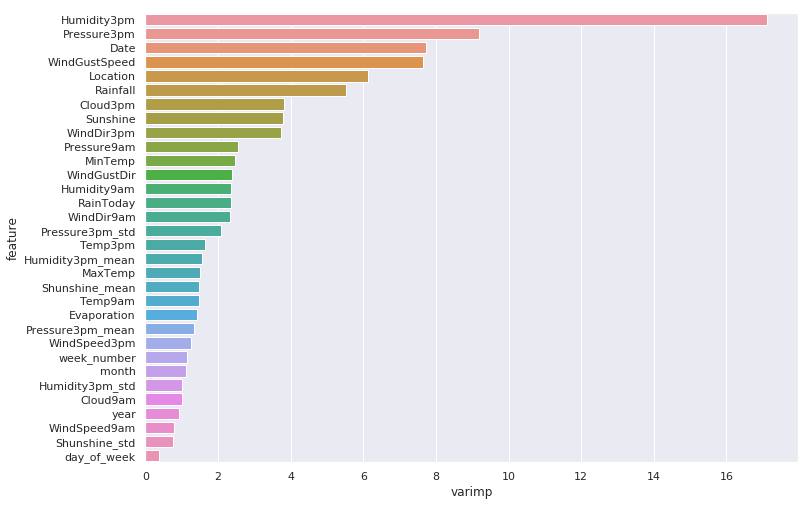

In [289]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
cat_feature_imp = pd.DataFrame([CatBoost.feature_names_ , CatBoost.feature_importances_]).T
cat_feature_imp.columns = ["feature","varimp"]
cat_feature_imp = cat_feature_imp.sort_values(by="varimp", ascending = False)
sns.barplot(y="feature", x="varimp",data = cat_feature_imp, )
plt.show()

In [20]:
rainidx = caty_Test == 1

In [302]:
catprob = CatBoost.predict_proba(test_X)
y_true = caty_Test
y_hat = np.round(catprob[:,1]).astype(int)
cat_result = ConfusionMatrix(y_true, y_hat)
print(cat_reulst)

Predict     0           1           
Actual
0           31435       1741        

1           3473        6009        





Overall Statistics : 

95% CI                                                            (0.87466,0.88088)
AUNP                                                              0.79062
AUNU                                                              0.79062
Bennett S                                                         0.75554
CBA                                                               0.76712
Chi-Squared                                                       16758.0229
Chi-Squared DF                                                    1
Conditional Entropy                                               0.44152
Cramer V                                                          0.62677
Cross Entropy                                                     0.77189
Gwet AC1                                                          0.81963
Hamming Loss                    

/root/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


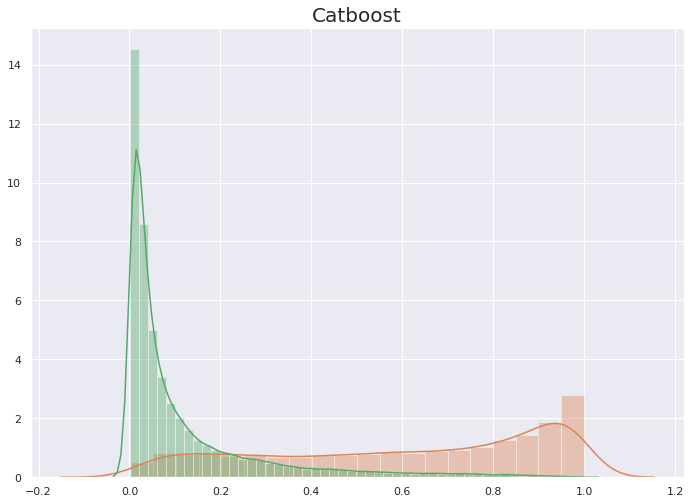

In [293]:
ProbDensity(catprob , rainidx, title = "Catboost")

## LightGBM

In [21]:
#catX_train[]
char = catX_train.select_dtypes("object").columns.tolist()
lgb_train = catX_train.copy()
lgb_test = catX_Test.copy()
for i in char :
    lgb_train[i] = lgb_train[i].astype("category").cat.codes
    lgb_test[i] = lgb_test[i].astype("category").cat.codes

In [25]:
lgb_train = lgb_train # .astype(float)
lgb_test  = lgb_test # .astype(float)
cat_feature_name = list(lgb_train.columns[cat_features])
print(cat_feature_name)
d_train = lgb.Dataset(lgb_train, label=caty_train, 
                      categorical_feature=cat_feature_name,
                      free_raw_data=False
                     )

['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'Date', 'year', 'day_of_week', 'month', 'week_number']


## **Bayes Optimization** Lightgbm 


In [ ]:
from bayes_opt import BayesianOptimization
n_folds = 5
random_seed=6
learning_rate=0.05

from sklearn.metrics import f1_score

def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

def learning_rate_005_decay_power_099(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
    params = {'application':'binary','num_iterations':4000, 
              'learning_rate':0.05, 'early_stopping_round':100,
              'metric':'auc',
              "objective" : "binary",
              "num_threads" : 20 ,
             }
    params["num_leaves"] = int(round(num_leaves))
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
    params['max_depth'] = int(round(max_depth))
    params['lambda_l1'] = max(lambda_l1, 0)
    params['lambda_l2'] = max(lambda_l2, 0)
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight
    evals_result = {}
    cv_result = lgb.cv(params, d_train,
                       nfold=n_folds, seed=random_seed, 
                       stratified=True, verbose_eval =200, 
                       metrics=['auc',"binary_logloss"],
                       feval=lgb_f1_score, evals_result=evals_result
                      )
    return max(cv_result['auc-mean'])

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (24, 45),
                                        'feature_fraction': (0.1, 0.9),
                                        'bagging_fraction': (0.8, 1),
                                        'max_depth': (5, 8.99),
                                        'lambda_l1': (0, 5),
                                        'lambda_l2': (0, 3),
                                        'min_split_gain': (0.001, 0.1),
                                        'min_child_weight': (5, 50)}, random_state=0)
init_round=5
opt_round = 10
lgbBO.maximize(init_points=init_round, n_iter=opt_round)
lgbBO.points_to_csv("lgb_bayes_opt_result.csv")
params = lgbBO.res['max']['max_params']
lgb2 = lgb.train(params, d_train , 100)
#lgb2 = lgb.train(params, d_train, 100)
lgb_prob = lgb2.predict( lgb_test.values )

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------------------
[200]	cv_agg's auc: 0.901739 + 0.00269936
[400]	cv_agg's auc: 0.906298 + 0.00259413
[600]	cv_agg's auc: 0.908788 + 0.00253752
[800]	cv_agg's auc: 0.910619 + 0.00248095
[1000]	cv_agg's auc: 0.911702 + 0.00249626
[1200]	cv_agg's auc: 0.912119 + 0.00240634
[1400]	cv_agg's auc: 0.912415 + 0.0024339
[1600]	cv_agg's auc: 0.912712 + 0.00239692
|  1        |  0.9127   |  0.9098   |  0.6722   |  3.014    |  1.635    |  6.69     |  34.07    |  0.04432  |  42.73    |
[200]	cv_agg's auc: 0.899619 + 0.00334921
[400]	cv_agg's auc: 0.905059 + 0.00319014
[600]	cv_agg's auc: 0.90766 + 0.0029595
[800]	cv_agg's auc: 0.908977 + 0.00286414
[1000]	cv_agg's auc: 0.910199 + 0.00278494
[1200]	cv_agg's auc: 0.911079 + 0.00260136
[1400]	cv_agg's auc: 0.911749 + 0.00256113


In [298]:
params = {'application': 'binary',
          "max_depth" : 8 , 
          "metric" : "f1", 
          'is_unbalance': 'true',
          'objective':'binary',
          'device': 'gpu',
          'gpu_platform_id': 0,
          'gpu_device_id': 0
         }

def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

eval_result_2 = {}
lgb2 = lgb.train(params, d_train , 100)
#lgb2 = lgb.train(params, d_train, 100)
lgb_prob = lgb2.predict( lgb_test.values )

['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'Date', 'year', 'day_of_week', 'month', 'week_number']


/root/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [299]:
y_true = caty_Test
y_hat = np.round(lgb_prob).astype(int)
lgb_result = ConfusionMatrix(y_true, y_hat)
print(lgb_result)

Predict     0           1           
Actual
0           27462       5714        

1           2465        7017        





Overall Statistics : 

95% CI                                                            (0.80453,0.812)
AUNP                                                              0.7839
AUNU                                                              0.7839
Bennett S                                                         0.61653
CBA                                                               0.68947
Chi-Squared                                                       11355.09508
Chi-Squared DF                                                    1
Conditional Entropy                                               0.69922
Cramer V                                                          0.51594
Cross Entropy                                                     0.78546
Gwet AC1                                                          0.68816
Hamming Loss                       

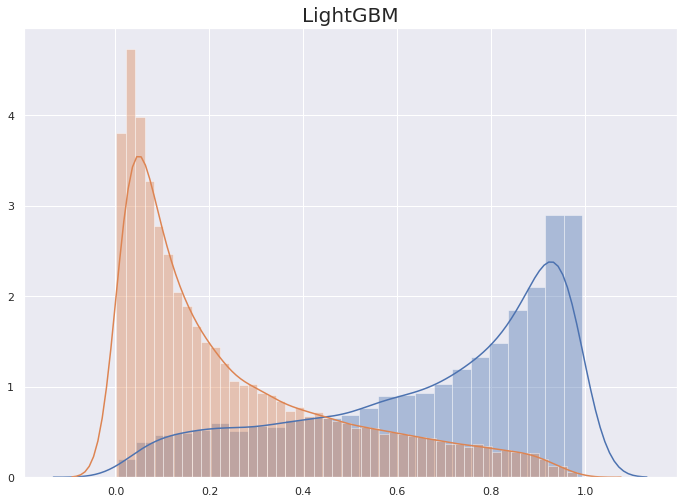

In [300]:
ProbDensity(lgb_prob , rainidx, "LightGBM")

##  Catboost **vs** Lightgbm

In [303]:
cp = Compare({"catboost":cat_result , "lightgbm":lgb_result })
print(cp)
print(cp.best_name , "\n" , cp.best)

Best : catboost

Rank  Name        Class-Score   Overall-Score
1     catboost    3.2           3.05
2     lightgbm    2.7           2.43333

catboost 
 Predict     0           1           
Actual
0           31435       1741        

1           3473        6009        





Overall Statistics : 

95% CI                                                            (0.87466,0.88088)
AUNP                                                              0.79062
AUNU                                                              0.79062
Bennett S                                                         0.75554
CBA                                                               0.76712
Chi-Squared                                                       16758.0229
Chi-Squared DF                                                    1
Conditional Entropy                                               0.44152
Cramer V                                                          0.62677
Cross Entropy               

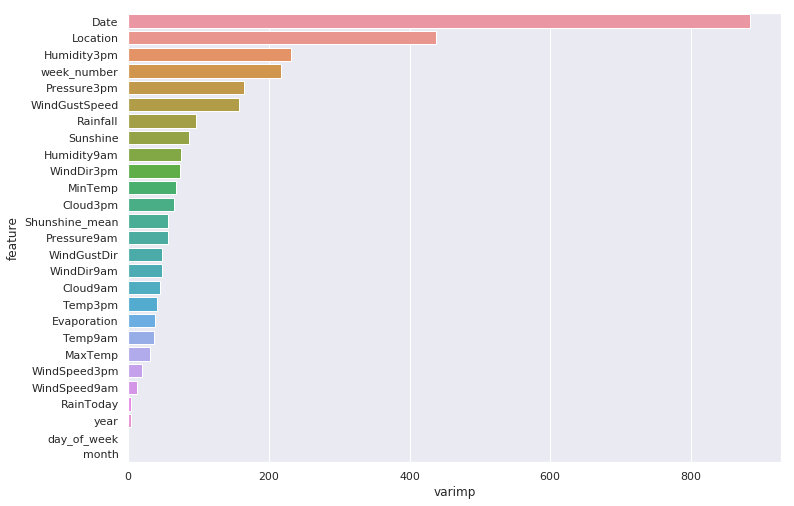

In [189]:
feature_importance = pd.DataFrame([lgb2.feature_name() , lgb2.feature_importance()]).T
feature_importance.columns = ["feature", "varimp"]
feature_importance = feature_importance.sort_values(["varimp"], ascending = False)
sns.barplot(y="feature", x="varimp",data = feature_importance)
plt.show()